In [1]:
# Importing packages
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\anand\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [2]:
# Helper function to standardize columns at beginning - includes trim, normalize spaces, snake-case, lowercase etc...
def standardize_columns(df):
  cols = []
  for c in df.columns:
    c2 = str(c).strip()  # Removes leading and trailing spaces
    c2 = " ".join(c2.split())
    c2 = c2.replace(" ", "_")
    c2 = c2.replace("(", "").replace(")", "")
    c2 = c2.replace("/", "_per_")
    c2 = c2.lower()
    cols.append(c2)  # Adds/appends the transformed column names into cols[]
    
  df.columns = cols
  return df

In [3]:
# Function to identify outliers in the data using IQR(InterQuartile Range)
def cap_outliers_iqr(df, col, k=1.5):
  if col not in df.columns:
    return df
  
  x=df[col].dropna()
  if len(x) < 10:
    return df
  
  q1 = x.quantile(0.25)   # Setting range for 25%
  q3 = x.quantile(0.75)   # Setting range for 75%
  iqr = q3 - q1           # Picking IQR
  
  # Defining high and low values - Values less than low and greater than high are outliers. Hence we remove these values
  low = q1 - k * iqr
  high = q3 + k * iqr
  
  df[col] = df[col].clip(low, high)
  return df

In [4]:
# Takes a list of column names (usually from a DataFrame) and:
# Cleans invalid characters
# Standardizes formatting
# Ensures all column names are unique
# Prevents empty or broken names
# This is commonly used before model training, feature engineering, or saving datasets.

def clean_and_make_unique_feature_names(columns):
  cleaned = []     # final list of cleaned column names
  counts = {}      # tracks how many times a name appears (for uniqueness)
  
  for c in columns:
    c = str(c)     # Convert column name to string
    c = pd.Series([c]).str.replace(r"[^A-Za-z0-9_]", "_", regex=True).iloc[0]  # Replace invalid characters
    c = pd.Series([c]).str.replace(r"_+", "_", regex=True).iloc[0]             # Collapse multiple underscores
    c = c.strip("_")                                                           # Remove underscores from both ends. Removes leading and trailing _
    
    if c == "":
      c = "feature"                                                            # Handle empty names
      
    if c not in counts:                                                        # Ensure uniqueness
      counts[c] = 1
      cleaned.append(c)
    else:
      counts[c] += 1
      cleaned.append(f"{c}__{counts[c]}")
  return cleaned

In [5]:
# It estimates a prediction interval for a regression model using bootstrap resampling of residuals.

def bootstrap_prediction_interval(
    model,
    X_train,          # training features used to compute residuals
    y_train,          # true training targets
    X_new,            # new data point for prediction
    n_boot=200,       # number of bootstrap simulations
    alpha=0.10,       # significance level (10% → 90% interval)
    random_state=42
):
    # Random generator for reproducibility (It makes random operations give the same result every time you run the code.)
    rng = np.random.RandomState(random_state)

    # Model predictions on training data
    y_train_pred = model.predict(X_train)

    # Residuals = actual - predicted
    residuals = np.array(y_train) - np.array(y_train_pred)

    # Point prediction for new input
    y_new_pred = float(model.predict(X_new)[0])

    simulated_predictions = []

    # Bootstrap: add resampled residuals to new prediction
    for _ in range(n_boot):
      sampled_residual = rng.choice(residuals, size=1, replace=True)[0]
      simulated_predictions.append(y_new_pred + sampled_residual)

    # Lower and upper bounds of prediction interval (Lower and upper bounds quantify the uncertainty of a prediction — they tell us the range in which the true value is likely to lie.)
    lower_bound = np.percentile(simulated_predictions, 100 * (alpha / 2))
    upper_bound = np.percentile(simulated_predictions, 100 * (1 - alpha / 2))

    # Return point prediction and prediction interval
    return y_new_pred, lower_bound, upper_bound


#### LOADING THE DATASET

In [6]:
df = pd.read_csv("workout_data.csv")
print("Original shape:", df.shape)
df.head()

Original shape: (20000, 54)


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,High
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,5.264685e+19,Low


In [7]:
# Standardize the columns
df = standardize_columns(df=df)
print("After columns standardization: ", df.shape)

After columns standardization:  (20000, 54)


In [8]:
# Basic quality checks
print("Missing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))

Missing values (top 15):
age                                0
gender                             0
weight_kg                          0
height_m                           0
max_bpm                            0
avg_bpm                            0
resting_bpm                        0
session_duration_hours             0
calories_burned                    0
workout_type                       0
fat_percentage                     0
water_intake_liters                0
workout_frequency_days_per_week    0
experience_level                   0
bmi                                0
dtype: int64


In [9]:
# To check for duplicates and if present then remove them from the dataframe

duplicates = df.duplicated().sum()
print("Duplicate rows: ", duplicates)

if duplicates > 0:
  df = df.drop_duplicates().reset_index(drop=True)
  print(f"After dropping duplicates: {df.shape}")

Duplicate rows:  0


In [10]:
# Type validation + unit checks
# Convert object columns to numeric when most values are numeric
for column_name in df.columns:
    # Process only object (string/mixed-type) columns
    if df[column_name].dtype == "object":

        # Try converting values to numeric; invalid values become NaN
        numeric_version = pd.to_numeric(df[column_name], errors="coerce")
        
        # Check if at least 80% of values are valid numbers
        if numeric_version.notna().mean() >= 0.80:
            
            # Replace original column with numeric version
            df[column_name] = numeric_version

# Sanity check for human height (in meters)
if "height_m" in df.columns:

    # Count rows with unrealistic height values
    invalid_height_count = (
        (df["height_m"] < 1.4) | (df["height_m"] > 2.1)
    ).sum()
    
    print(
        "Height sanity check (1.4–2.1 m): bad_rows =",
        int(invalid_height_count)
    )


# Sanity check for workout/session duration (in hours)
if "session_duration_hours" in df.columns:
    
    # Count sessions that are too short or too long
    invalid_duration_count = (
        (df["session_duration_hours"] < 0.25) |
        (df["session_duration_hours"] > 2.0)
    ).sum()
    
    print(
        "Duration sanity check (0.25–2 hours): bad_rows =",
        int(invalid_duration_count)
    )

Height sanity check (1.4–2.1 m): bad_rows = 0
Duration sanity check (0.25–2 hours): bad_rows = 8


#### FEATURE ENGINEERING

In [11]:
# Check if both weight and height columns exist (required to calculate BMI)
if "weight_kg" in df.columns and "height_m" in df.columns:
    df["bmi_calc"] = df["weight_kg"] / (df["height_m"] ** 2)   # Calculate BMI using the formula: weight (kg) / height² (m²)


# Check if both original BMI and calculated BMI columns exist
if "bmi" in df.columns and "bmi_calc" in df.columns:
    mismatch = (df["bmi"] - df["bmi_calc"]).abs()  # Compute absolute difference between reported BMI and calculated BMI
    frac_big = (mismatch > 1.0).mean()             # Calculate fraction of rows where BMI difference is greater than 1.0
    
    print("\nBMI mismatch fraction (abs diff > 1.0):", round(float(frac_big), 4))
    
    if frac_big > 0.30:
        # Drop unreliable BMI column and keep computed BMI instead
        print("Large mismatch -> dropping 'bmi' and keeping 'bmi_calc'")
        df = df.drop(columns=["bmi"])



BMI mismatch fraction (abs diff > 1.0): 0.0


In [12]:
# Check if calories burned and session duration columns exist
if "calories_burned" in df.columns and "session_duration_hours" in df.columns:
    
    # Small epsilon (1e-9) added to avoid division by zero
    # Compute calories burned per minute (convert hours to minutes)
    df["calories_per_min"] = ( df["calories_burned"] / (df["session_duration_hours"] * 60.0 + 1e-9))


# Check if all heart rate related columns exist
if all(c in df.columns for c in ["max_bpm", "avg_bpm", "resting_bpm"]):
    
    # Calculate heart rate reserve (max effort capacity)
    df["heart_rate_reserve"] = df["max_bpm"] - df["resting_bpm"]
    
    # Compute workout intensity as fraction of max heart rate
    # Epsilon added to prevent division by zero
    df["workout_intensity"] = df["avg_bpm"] / (df["max_bpm"] + 1e-9)


#### OUTLIER HANDLING

In [13]:
# Loop through selected numeric columns where outliers are likely
for col in ["calories_burned", "avg_bpm", "weight_kg", "session_duration_hours"]:
  
  # Check if column exists and is of numeric type
  if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
    # Cap outliers in the column using IQR method (k=1.5)
    df = cap_outliers_iqr(df, col, k=1.5)


#### DROP SUSPICIOUS AND LEAKY COLUMNS

In [14]:
leaky_cols = []
if "burn_calories_bin" in df.columns:
  leaky_cols.append("burn_calories_bin")
  
if "burns_calories_per_30_min_bc" in df.columns:
  leaky_cols.append("burns_calories_per_30_min_bc")
  
print("Suspicious/leaky columns found:", leaky_cols)

df_model = df.drop(columns=leaky_cols, errors="ignore").copy()

Suspicious/leaky columns found: ['burns_calories_per_30_min_bc']


#### EDA

EDA: Shape used for modelling: (20000, 56)


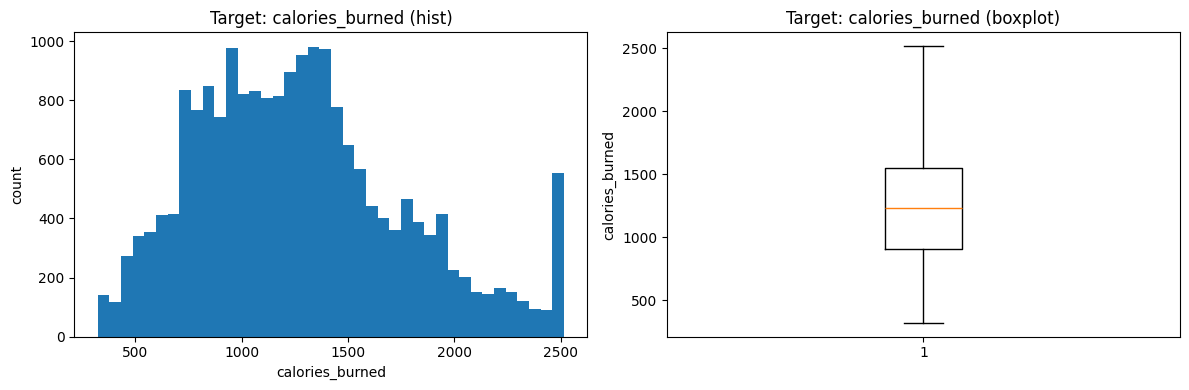

In [15]:
print("EDA: Shape used for modelling:", df_model.shape)

if "calories_burned" in df_model.columns:
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.hist(df_model["calories_burned"], bins=40)
  plt.title("Target: calories_burned (hist)")
  plt.xlabel("calories_burned")
  plt.ylabel("count")
  
  
  plt.subplot(1, 2, 2)
  plt.boxplot(df_model["calories_burned"].values, vert=True)
  plt.title("Target: calories_burned (boxplot)")
  plt.ylabel("calories_burned")
  plt.tight_layout()
  plt.show()

#### Prepare features (robust encoding => all numeric + LightGBM-safe names)

In [18]:
target_col = "calories_burned"  # Change the name to calories_burned later
if target_col not in df_model.columns:
  raise ValueError("Target column 'calories_burned' not found.")

In [19]:
y = df_model[target_col].copy()
X = df_model.drop(columns=target_col, errors="ignore").copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Keep raw copies for frequency maps (before dropping)
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

# Fill missing values in RAW
for c in X_train_raw.columns:
  if X_train_raw[c].dtype == "object":
    X_train_raw[c] = X_train_raw[c].fillna("unknown").astype(str)
    X_test_raw[c] = X_test_raw[c].fillna("unknown").astype(str)
  else:
    med = X_train_raw[c].median() if pd.api.types.is_numeric_dtype(X_train_raw[c]) else 0
    X_train_raw[c] = X_train_raw[c].fillna(med)
    X_test_raw[c] = X_test_raw[c].fillna(med)

In [20]:
# Working on copies
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

In [21]:
# Detect categorical columns dynamically
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

LOW_CARD_MAX = 20
low_card_cols = []
high_card_cols = []

In [22]:
for c in cat_cols:
  num = X_train[c].nunique(dropna=False)
  if num <= LOW_CARD_MAX:
    low_card_cols.append(c)
  else:
    high_card_cols.append(c)
    

print(f"Categorical columns detected: {len(cat_cols)}")
print(f"Low-card columns (one-hot encoding): {len(low_card_cols)}")
print(f"High-card columns (freq): {len(high_card_cols)}")

Categorical columns detected: 15
Low-card columns (one-hot encoding): 11
High-card columns (freq): 4


In [23]:
# Frequency encoding for high-card (train-only maps)
freq_maps = {}
for c in high_card_cols:
  freq = X_train_raw[c].astype(str).value_counts(dropna=False) / len(X_train_raw)
  freq_maps[c] = freq
  X_train[c + "_freq"] = X_train[c].astype(str).map(freq).fillna(0.0)
  X_test[c + "_freq"] = X_test[c].astype(str).map(freq).fillna(0.0)
  X_train = X_train.drop(columns=[c])
  X_test = X_test.drop(columns=[c])

In [24]:
# One hot encoding for low-card
if len(low_card_cols) > 0:
  X_train = pd.get_dummies(X_train, columns=low_card_cols, drop_first=True)
  X_test = pd.get_dummies(X_test, columns=low_card_cols, drop_first=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [25]:
# Force numeric - to prevent errors 
for c in X_train.columns:
  X_train[c] = pd.to_numeric(X_train[c], errors="coerce").fillna(0.0)
  X_test[c] = pd.to_numeric(X_test[c], errors="coerce").fillna(0.0)

In [26]:
# LightGBM fix - sanitize feature names after using .get_dummies()
safe_cols = clean_and_make_unique_feature_names(X_train.columns)
X_train.columns = safe_cols
X_test.columns = safe_cols

print(f"Final feature shape: X_train - {X_train.shape}, X_test - {X_test.shape}")
print(f"Sample feature names(first 10): {list(X_train.columns[:10])}")

Final feature shape: X_train - (16000, 104), X_test - (4000, 104)
Sample feature names(first 10): ['age', 'weight_kg', 'height_m', 'max_bpm', 'avg_bpm', 'resting_bpm', 'session_duration_hours', 'fat_percentage', 'water_intake_liters', 'workout_frequency_days_per_week']


In [33]:
# Scaling for Linear + SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
print(X_train_scaled)

[[-1.64234669 -0.00810689  0.37280347 ... -0.5782163   1.72429146
  -0.57369368]
 [-0.89571244 -1.00374969 -0.8826252  ... -0.5782163  -0.57994836
   1.74309049]
 [ 0.81594248 -0.20676246 -0.80416091 ... -0.5782163   1.72429146
  -0.57369368]
 ...
 [-1.46846167  1.26659968  0.92205351 ... -0.5782163  -0.57994836
   1.74309049]
 [ 1.57576233 -0.38602546  0.21587488 ...  1.72945662 -0.57994836
  -0.57369368]
 [-0.01969454  1.33565614  1.70669643 ... -0.5782163  -0.57994836
   1.74309049]]


In [35]:
print(X_test_scaled)

[[-1.04240217  2.42684281  0.29433918 ... -0.5782163   1.72429146
  -0.57369368]
 [-1.45445198  0.69002554 -0.9610895  ...  1.72945662 -0.57994836
  -0.57369368]
 [ 1.25189118  0.08034214 -0.01951799 ... -0.5782163  -0.57994836
   1.74309049]
 ...
 [ 1.11591474  0.42467846 -0.01951799 ... -0.5782163   1.72429146
  -0.57369368]
 [-0.33367649 -1.42707525 -0.80416091 ... -0.5782163   1.72429146
  -0.57369368]
 [ 1.68619168 -0.62535813  0.0589463  ... -0.5782163  -0.57994836
  -0.57369368]]


In [38]:
from sklearn.metrics import root_mean_squared_error

# Training models 
def eval_model(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return mae, rmse, r2

In [ ]:
# Training Linear Regression Model
results = []
# print("Model Training and Evaluation for Linear Regression")

# lr = LinearRegression()
# lr.fit(X_train_scaled, y_train)
# lr_pred = lr.predict(X_test_scaled)
# mae, rmse, r2 = eval_model(y_true=y_test, y_pred=lr_pred)
# results.append(["Linear Regression", mae, rmse, r2])

# print(f"Linear Regression MAE: {mae: 8.2f} RMSE: {rmse: 8.2f} R2: {r2: 7.4f}")

Model Training and Evaluation for Linear Regression
Linear Regression MAE:    12.69 RMSE:    24.76 R2:  0.9974


In [52]:
results = []

trained_models = {}  # <-- ONLY addition: store trained models

models = {
  "Linear Regression": LinearRegression(),
  "SVR": SVR(kernel="rbf", C=50, gamma="scale", epsilon=10),
  "Random Forest": RandomForestRegressor(
      n_estimators=250, max_depth=18, random_state=42, n_jobs=-1
  ),
  "LightGBM": LGBMRegressor(
      n_estimators=500, learning_rate=0.05,
      subsample=0.9, colsample_bytree=0.9, random_state=42
  ),
  "XGBRegressor": XGBRegressor(
      n_estimators=500, learning_rate=0.05, max_depth=6,
      subsample=0.9, colsample_bytree=0.9,
      random_state=42, verbosity=0
  ),
}

model_list = []
r2_list = []

for model_name, model in models.items():

  # keep scaling logic exactly as you had it
  X_tr = X_train_scaled if model_name in ["Linear Regression", "SVR"] else X_train
  X_te = X_test_scaled if model_name in ["Linear Regression", "SVR"] else X_test

  model.fit(X_tr, y_train)

  trained_models[model_name] = model  # <-- ONLY new line

  y_train_pred = model.predict(X_tr)
  y_test_pred = model.predict(X_te)

  train_mae, train_rmse, train_r2 = eval_model(y_train, y_train_pred)
  test_mae, test_rmse, test_r2 = eval_model(y_test, y_test_pred)

  print(model_name)
  print("Model performance for train data")
  print(f"- RMSE: {train_rmse:.4f}")
  print(f"- MAE: {train_mae:.4f}")
  print(f"- R2 Score: {train_r2:.4f}")

  print("--------------------------------------------------")

  print("Model performance for test data")
  print(f"- RMSE: {test_rmse:.4f}")
  print(f"- MAE: {test_mae:.4f}")
  print(f"- R2 Score: {test_r2:.4f}")

  model_list.append(model_name)
  r2_list.append(test_r2)
  results.append([model_name, test_mae, test_rmse, test_r2])

  print("=" * 35)


Linear Regression
Model performance for train data
- RMSE: 25.2398
- MAE: 12.6636
- R2 Score: 0.9974
--------------------------------------------------
Model performance for test data
- RMSE: 24.7552
- MAE: 12.6919
- R2 Score: 0.9974
SVR
Model performance for train data
- RMSE: 41.4790
- MAE: 24.0955
- R2 Score: 0.9929
--------------------------------------------------
Model performance for test data
- RMSE: 49.6052
- MAE: 33.4080
- R2 Score: 0.9897
Random Forest
Model performance for train data
- RMSE: 0.9692
- MAE: 0.2532
- R2 Score: 1.0000
--------------------------------------------------
Model performance for test data
- RMSE: 3.8616
- MAE: 0.7702
- R2 Score: 0.9999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9001
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 104
[LightGBM] [Info] Start traini

In [54]:
print(results)

[['Linear Regression', 12.691920950252392, 24.755162907205996, 0.997431040334636], ['SVR', 33.407984412486314, 49.60524030102453, 0.9896847246830031], ['Random Forest', 0.7702471548871981, 3.861646896917078, 0.9999374869298826], ['LightGBM', 3.5693396712689482, 6.716865285766201, 0.9998108706262535], ['XGBRegressor', 2.707780316467285, 4.613934558981414, 0.9999107581490739]]


In [55]:
# Converting the results(list) to a DataFrame
results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE", "R2_Score"]
).sort_values("RMSE")

print("Model Comparison (sorted by RMSE):")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
print(f"The best model is: {best_model_name}")

Model Comparison (sorted by RMSE):
               Model        MAE       RMSE  R2_Score
2      Random Forest   0.770247   3.861647  0.999937
4       XGBRegressor   2.707780   4.613935  0.999911
3           LightGBM   3.569340   6.716865  0.999811
0  Linear Regression  12.691921  24.755163  0.997431
1                SVR  33.407984  49.605240  0.989685
The best model is: Random Forest


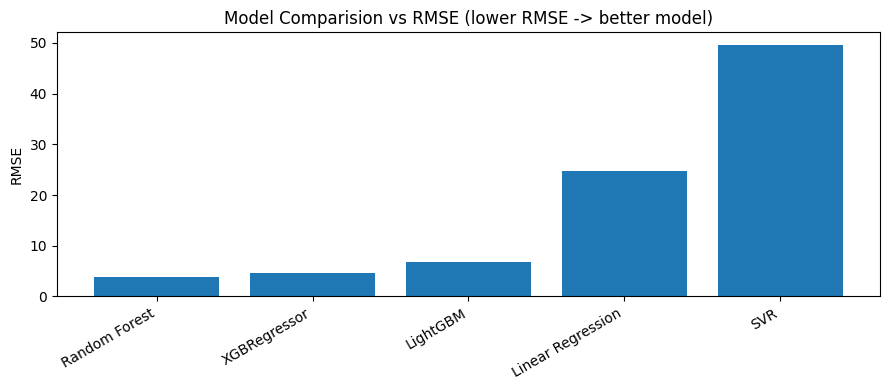

In [56]:
# Plotting the graphs for model comparision
plt.figure(figsize=(9, 4))
plt.bar(results_df["Model"], results_df["RMSE"]) # Bar graph representing Model and its RMSE Value
plt.title("Model Comparision vs RMSE (lower RMSE -> better model)")
plt.ylabel("RMSE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [57]:
best_model_name = results_df.iloc[0]["Model"]
print(f"The best model is: {best_model_name}")

The best model is: Random Forest


In [59]:
best_model = trained_models[best_model_name]
best_model

RandomForestRegressor(max_depth=18, n_estimators=250, n_jobs=-1,
                      random_state=42)

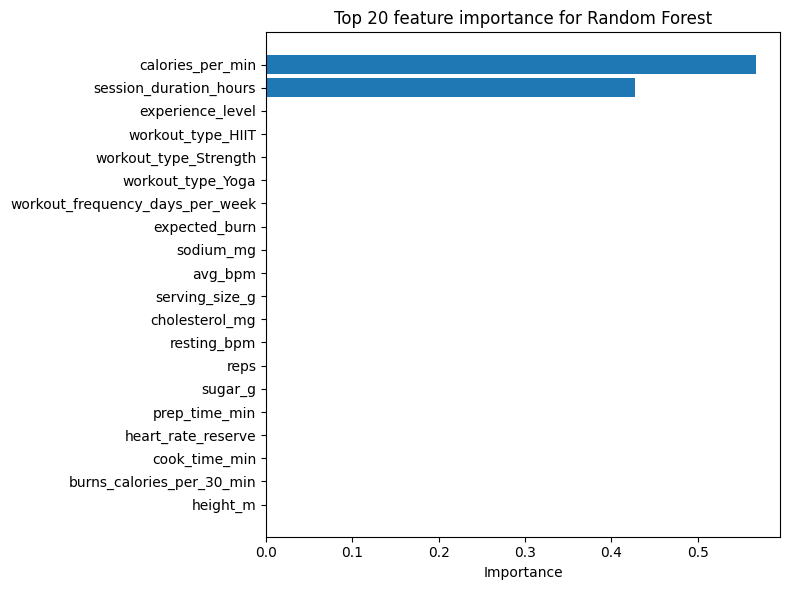

In [64]:
# Feature importance
if best_model_name in ["Random Forest", "LightGBM", "XGBRegressor"] and best_model is not None:

  fi = pd.DataFrame({
      "feature": X_train.columns,
      "importance": best_model.feature_importances_
  })

  fi = fi.sort_values("importance", ascending=False).head(20)

  plt.figure(figsize=(8, 6))
  plt.barh( list(reversed(fi["feature"].values)), list(reversed(fi["importance"].values)))
  plt.title(f"Top 20 feature importance for {best_model_name}")
  plt.xlabel("Importance")
  plt.tight_layout()
  plt.show()


In [69]:
# ROC Curve for best model (regresiion score used for classification)

uses_scaled = {"Linear Regression", "SVR"}

if "burns_calories_bin" in df.columns:
  y_bin_all = (df["burns_calories_bin"].astype(str).str.lower() == "high").astype(int)
else:
  thr = df_model["calories_burned"].quantile(0.75)
  y_bin_all = (df_model["calories_burned"] >= thr).astype(int)
  
y_bin_test = y_bin_all.loc[X_test_raw.index] 
# y_bin_test

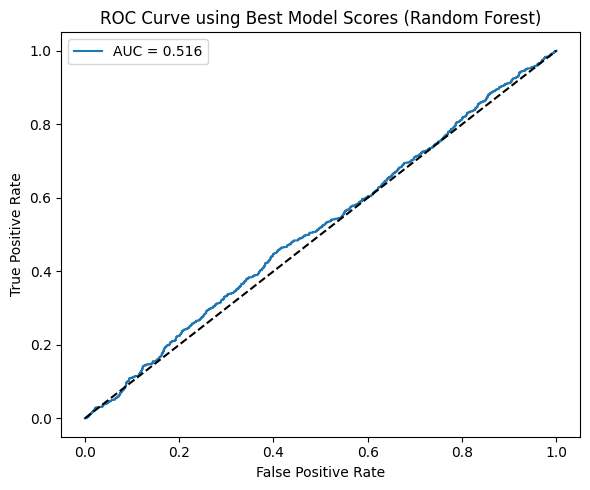

ROC-AUC score for the best model - Random Forest is 0.5158


In [70]:
if uses_scaled:
  score_test = best_model.predict(X_test_scaled)
else :
  score_test = best_model.predict(X_test)
  
auc = roc_auc_score(y_bin_test, score_test)
fpr, tpr, _ = roc_curve(y_bin_test, score_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title(f"ROC Curve using Best Model Scores ({best_model_name})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

print(f"ROC-AUC score for the best model - {best_model_name} is {round(float(auc), 4)}")

In [72]:
# New User Prediction + interval (uses same encoding + same safe feature name)
new_user = {
  "age": 30,
  "gender": "Other",
  "weight_kg": 70,
  "height_m": 1.75,
  "max_bpm": 190,
  "avg_bpm": 150,
  "resting_bpm": 65,
  "session_duration_hours": 1.0,
  "workout_type": "Cardio"
}

x_new = pd.DataFrame([new_user])
x_new = standardize_columns(x_new)

In [73]:
# Feature engineering for x_new
if "weight_kg" in x_new.columns and "height_m" in x_new.columns:
  x_new["bmi_calc"] = x_new["weight_kg"] / (x_new["height_m"] ** 2)
  
if all (c in x_new.columns for c in ["max_bpm", "avg_bpm", "resting_bpm"]):
  x_new["heart_rate_reserve"] = x_new["max_bpm"] - x_new["resting_bpm"]
  x_new["workout_intensity"] = x_new["avg_bpm"] / (x_new["max_bpm"] + 1e-9)

In [74]:
# Ensure all the RAW columns exist
for c in X_train_raw.columns:
  if c not in x_new.columns:
    x_new[c] =np.nan
    
# Fill missing values
for c in x_new.columns:
  if c in cat_cols:
    x_new[c] = x_new[c].fillna("unknown").astype(str)
  else:
    if c in X_train_raw.columns and pd.api.types.is_numeric_dtype(X_train[c]):
      x_new[c] = pd.to_numeric(x_new[c], errors="coerce").fillna(X_train_raw[c].median())
    else:
      x_new[c] = pd.to_numeric(x_new[c], errors="coerce").fillna(0.0)

In [75]:
# Apply Frequency Encoding
for c in high_card_cols:
  if c in x_new.columns:
    freq = freq_maps.get(c, None)
    if freq is None:
      x_new[c + "_freq"] = 0.0
    else :
      x_new[c + "_freq"] = x_new[c].astype(str).map(freq).fillna(0.0)
    
    x_new = x_new.drop(columns=[c])

In [77]:
# One hot encoding - low-card
if len(low_card_cols) > 0:
  x_new = pd.get_dummies(x_new, columns=[c for c in low_card_cols if c in x_new.columns], drop_first=True)
  
  
# Align to training encoded columns (by current names)
x_new, _ = x_new.align(pd.DataFrame(columns=X_train.columns), join="right", axis=1, fill_value=0)
x_new = x_new[X_train.columns]

# Force numeric
for c in x_new.columns:
  x_new[c] = pd.to_numeric(x_new[c], errors="coerce").fillna(0.0)

In [79]:
# Predict + interval
if uses_scaled:
  x_new_scaled = scaler.transform(x_new)
  pred, lo, hi = bootstrap_prediction_interval(best_model, X_train=X_train_scaled, y_train=y_train.values, X_new=x_new_scaled, n_boot=200)
else :
  pred, lo, hi = bootstrap_prediction_interval(best_model, X_train=X_train.values, y_train=y_train.values, X_new=x_new.values, n_boot=200)
  

print(f"\n ---- New User Prediction ----")
print(f"Predicted Calories Burned: {round(float(pred), 2)}")
print(f"Approx. 90% Prediction Interval: {round(float(lo), 2)}, {round(float(hi), 2)} ")


 ---- New User Prediction ----
Predicted Calories Burned: 358.12
Approx. 90% Prediction Interval: 525.38, 1855.39 
